[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1kYjGK-X8u_C0vR7T5M1xyMYVgLVjDYc1/view?usp=sharing)

In [1]:
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import os
import re
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import f1_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Add dataset path
path = "./data/"
folder = "raw/"
filename = "Rest_Mex_Sentiment_Analysis_2023_Train.xlsx"
# reading the data
df = pd.read_excel(path + folder + filename)
df = df.fillna("")

In [3]:
def to_weights(x):
    return 1.0 / x

df["Polarity"] = df["Polarity"] - 1
X, y = df["Review"], df["Polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

datasets = pd.DataFrame({"X_train": X_train, "y_train": y_train})

test = pd.DataFrame({"X_test": X_test, "y_test": y_test})

print(f"Stratified sampling mode : ")
datasets["freq"] = datasets.groupby("y_train")["y_train"].transform("count")
test["freq"] = test.groupby("y_test")["y_test"].transform("count")
datasets_balanced = datasets.sample(
    n=len(datasets), replace=True, weights=datasets["freq"].apply(to_weights)
).copy()
test_balanced = test.sample(
    n=len(test), replace=True, weights=test["freq"].apply(to_weights)
).copy()

Stratified sampling mode : 


In [4]:
df["Polarity"].unique()

array([4, 3, 2, 0, 1], dtype=int64)

In [5]:
print(f"The values of the first 5 rows are : ")
datasets_balanced.head()

The values of the first 5 rows are : 


,X_train,y_train,freq
23452,Excelente vista al ser un penthouse! Calamares...,3,40524
178702,"No puedo negar que la arquitectura del museo, ...",1,4621
68269,Estaba a pocas cuadras de nuestro hotel así qu...,2,14564
221826,"Un restaurante buffet, con comida regular ,don...",0,3840
19486,Era refrescante encontrar un museo bellas arte...,2,14564


### Sentiment Analysis (Polarity)

In [6]:
def preprocess(X_batch, min_length=0, max_length=308, tensor_mode=True):
    X_batch = str(X_batch).lower()
    X_batch = re.sub(r"[á']", r"a", X_batch)
    X_batch = re.sub(r"[é']", r"e", X_batch)
    X_batch = re.sub(r"[í']", r"i", X_batch)
    X_batch = re.sub(r"[ó']", r"o", X_batch)
    X_batch = re.sub(r"[ú']", r"u", X_batch)
    # X_batch = ''.join(i for i, _ in itertools.groupby(X_batch))
    X_batch = re.sub(r"(.)\1+", r"\1", X_batch)
    X_batch = tf.strings.substr(X_batch, min_length, max_length)
    X_batch = tf.strings.regex_replace(X_batch, r"[^a-zA-Zñ']", r" ")
    X_batch = tf.strings.regex_replace(X_batch, r"[^\w\s]", r"")
    X_batch = tf.strings.split(X_batch)
    X_batch = [str(w).replace("b'", "").replace("'", "") for w in X_batch.numpy()]
    if tensor_mode:
        n = len(X_batch)
        X_add = [""] * (max_length - n)
        X_batch += X_add
        return tf.convert_to_tensor(X_batch)
    else:
        return X_batch

In [7]:
if os.path.exists("vocab.pkl"):
    with open("vocab.pkl", "rb") as file:
        vocabulary = pickle.load(file)
else:
    vocabulary = Counter()
    reviews = datasets.iloc[:, 0].apply(preprocess, , tensor_mode=False)
    for X_batch in reviews:
        vocabulary.update(X_batch)

    with open("vocab.pkl", "wb") as file:
        pickle.dump(vocabulary, file)

In [8]:
# top 5 most common words
vocabulary.most_common()[:5]

[('', 45103100), ('de', 321876), ('la', 274244), ('y', 259347), ('el', 207010)]

In [9]:
print(f"Total size of the vocabulary : ", "{:,}".format(len(vocabulary.most_common())))
print("-------------------------------------------------------")

Total size of the vocabulary :  77,716
-------------------------------------------------------


In [10]:
# let's truncate the vocabulary, keeping only the 10,000 most common words
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

# now we add a preprocessing step to replace each work with its ID
words = tf.constant(truncated_vocabulary)
words_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, words_ids)
# we will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [11]:
print(f"1) Example of use.")
print("-------------------------------------------------------")
text = "Muy buena la atención de principio a fin en el restaurante Serratta. Por parte de Jonathan. Recomendado."
print('preprocess text : ', preprocess(text))
#table.lookup(preprocess(text)).numpy()

1) Example of use.
-------------------------------------------------------
preprocess text :  tf.Tensor(
[b'muy' b'buena' b'la' b'atencion' b'de' b'principio' b'a' b'fin' b'en'
 b'el' b'restaurante' b'serata' b'por' b'parte' b'de' b'jonathan'
 b'recomendado' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b''

In [12]:
depth = 5


# now we create the encode_words() function that uses the table we just built
def encode_words(X_batch):
    if X_batch.isnumeric():
        X_batch = ""
    return list(table[preprocess(X_batch)].numpy())


datasets_balanced = datasets_balanced.drop(columns=["freq"])
test_balanced = test_balanced.drop(columns=["freq"])
training_sentences = datasets_balanced["X_train"].to_list()
testing_sentences = test_balanced["X_test"].to_list()

embed_size = 16
max_length = 32
trunc_type = "post"
padding_type = "post"
oov_tok = ""

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)

padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
padded.shape

(168640, 32)

In [13]:
if os.path.exists("train_x.pkl"):
    with open("train_x.pkl", "rb") as file:
        train_x = pickle.load(file)

    with open("test_x.pkl", "rb") as file:
        test_x = pickle.load(file)
else:
    train_x = np.array(
        [encode_words(sentence) for sentence in datasets_balanced["X_train"].to_list()]
    )
    test_x = np.array([encode_words(sentence) for sentence in test_balanced["X_test"].to_list()])

    with open("train_x.pkl", "wb") as file:
        pickle.dump(train_x, file)

    with open("test_x.pkl", "wb") as file:
        pickle.dump(test_x, file)

In [14]:
if os.path.exists("hub_train_x.pkl"):
    with open("hub_train_x.pkl", "rb") as file:
        hub_train_x = pickle.load(file)

    with open("hub_test_x.pkl", "rb") as file:
        hub_test_x = pickle.load(file)
else:
    hub_train_x = np.array([sentence for sentence in datasets_balanced["X_train"].to_list()])
    hub_test_x = np.array([sentence for sentence in test_balanced["X_test"].to_list()])

    with open("hub_train_x.pkl", "wb") as file:
        pickle.dump(hub_train_x, file)

    with open("hub_test_x.pkl", "wb") as file:
        pickle.dump(hub_test_x, file)

In [15]:
train_y = datasets_balanced["y_train"]
train_y = (tf.one_hot(train_y, depth)).numpy()

test_y = test_balanced["y_test"]
test_y = (tf.one_hot(test_y, depth)).numpy()

train_x.shape

(168640, 308)

In [16]:
train_y.shape

(168640, 5)

### Reusing Pretrained Embeddings

Epoch 1/35
5270/5270 [==============================] - 22s 4ms/step - loss: 0.5008 - accuracy: 0.3037 - val_loss: 0.4736 - val_accuracy: 0.3560
Epoch 2/35
5270/5270 [==============================] - 15s 3ms/step - loss: 0.4617 - accuracy: 0.3672 - val_loss: 0.4525 - val_accuracy: 0.3768
Epoch 3/35
5270/5270 [==============================] - 15s 3ms/step - loss: 0.4474 - accuracy: 0.3857 - val_loss: 0.4423 - val_accuracy: 0.3912
Epoch 4/35
5270/5270 [==============================] - 15s 3ms/step - loss: 0.4396 - accuracy: 0.3993 - val_loss: 0.4363 - val_accuracy: 0.4014
Epoch 5/35
5270/5270 [==============================] - 15s 3ms/step - loss: 0.4348 - accuracy: 0.4081 - val_loss: 0.4326 - val_accuracy: 0.4084
Epoch 6/35
5270/5270 [==============================] - 15s 3ms/step - loss: 0.4318 - accuracy: 0.4133 - val_loss: 0.4303 - val_accuracy: 0.4120
Epoch 7/35
5270/5270 [==============================] - 15s 3ms/step - loss: 0.4297 - accuracy: 0.4163 - val_loss: 0.4286 - val_ac

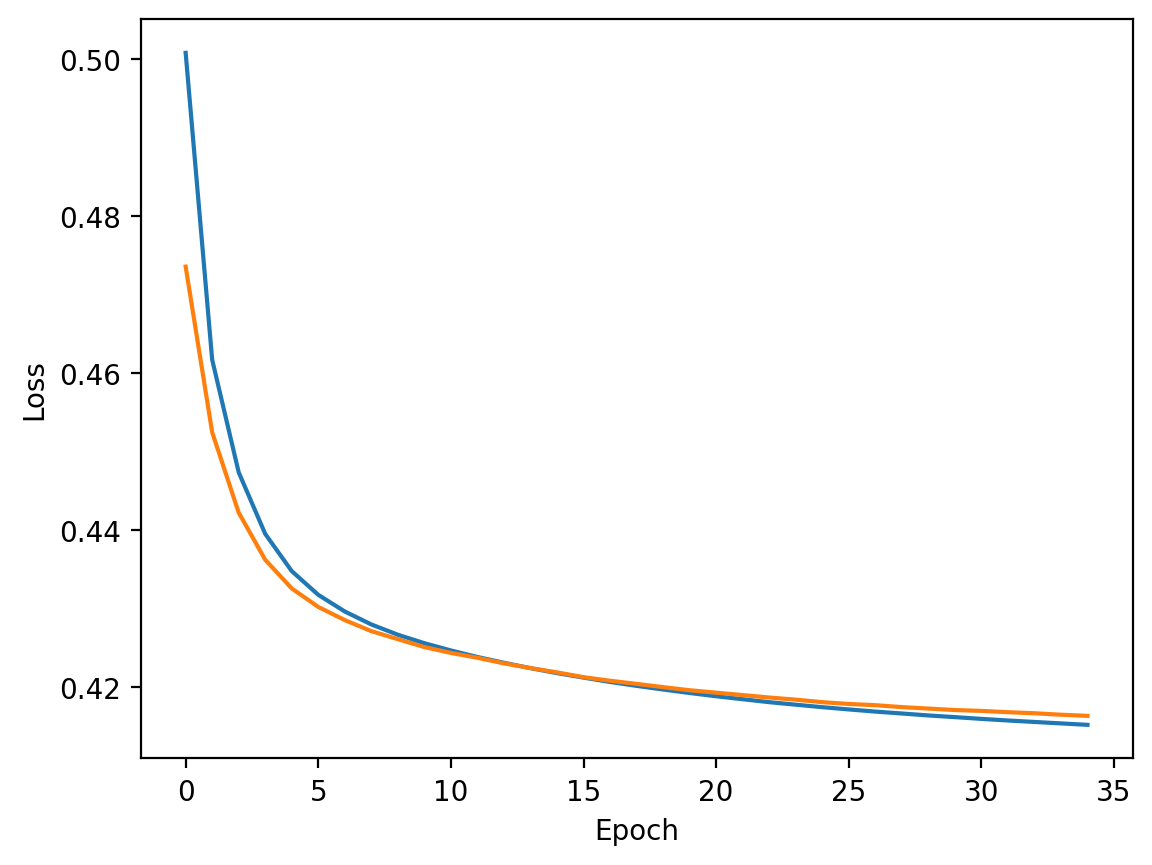

In [17]:
# TF Hub repository (https://tfhub.dev)

import tensorflow_hub as hub

model = tf.keras.Sequential(
    [
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/nnlm-es-dim50/1",
            output_shape=[50],
            input_shape=[],
            dtype=tf.string,
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

history = model.fit(hub_train_x, train_y, epochs=35, validation_data=(hub_test_x, test_y))

hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

# plot history
plt.plot(history.history["loss"], label="Train Error")
plt.plot(history.history["val_loss"], label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.save("saved_model/hub_model.h5")

Epoch 1/5
5270/5270 [==============================] - 276s 52ms/step - loss: 0.5067 - accuracy: 0.2102 - val_loss: 0.5001 - val_accuracy: 0.2233
Epoch 2/5
5270/5270 [==============================] - 356s 68ms/step - loss: 0.4995 - accuracy: 0.2269 - val_loss: 0.4988 - val_accuracy: 0.2222
Epoch 3/5
5270/5270 [==============================] - 241s 46ms/step - loss: 0.4974 - accuracy: 0.2405 - val_loss: 0.4956 - val_accuracy: 0.2443
Epoch 4/5
5270/5270 [==============================] - 290s 55ms/step - loss: 0.4950 - accuracy: 0.2433 - val_loss: 0.4940 - val_accuracy: 0.2455
Epoch 5/5
5270/5270 [==============================] - 244s 46ms/step - loss: 0.4944 - accuracy: 0.2439 - val_loss: 0.4937 - val_accuracy: 0.2430


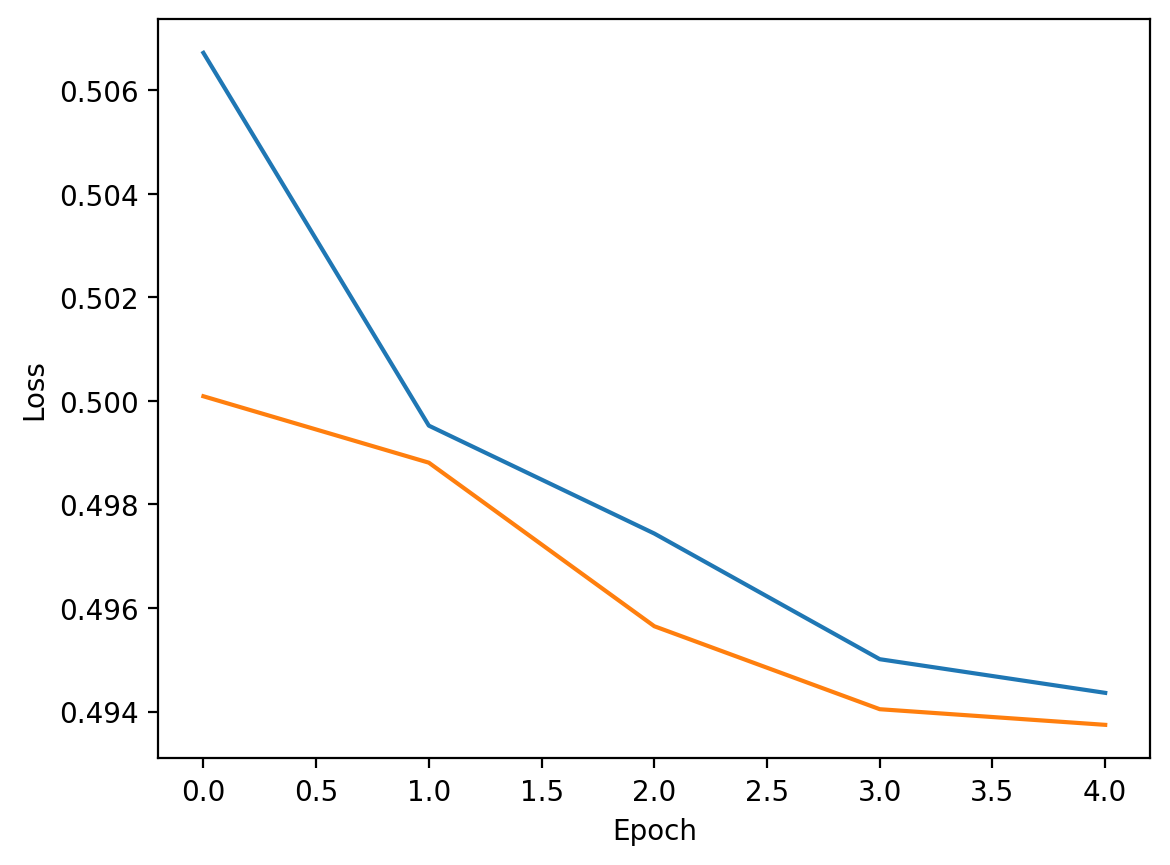

In [25]:
# at last we create the model and train it

model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(
            vocab_size, embed_size, input_shape=[None], input_length=max_length
        ),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

model2.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

history2 = model2.fit(padded, train_y, epochs=5, validation_data=(testing_padded, test_y))

hist2 = pd.DataFrame(history2.history)
hist2["epoch"] = history2.epoch
hist2.tail()

# plot history
plt.plot(history2.history["loss"], label="Train Error")
plt.plot(history2.history["val_loss"], label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model2.save("saved_model/my_model2.h5")

In [60]:
class Performance_Measures:

    """ Class with functions to measure performance of ML Models"""

    def __init__(self, true, pred, labels) -> None:
        self.labels = labels
        self.true = true
        self.pred = pred 

    #Performance Measure Res_T
    def F_mean(self):
        n = len(self.true)

        F_vec = f1_score(self.true, self.pred, average= None, labels= self.labels)
        a = np.sum(F_vec)

        for i in range(len(F_vec)):
            print("F-measure of label ", self.labels[i], " -> ", F_vec[i])

        print("Mean of F-measures -> ", a/n)
    
    #Performance Measure Res_P
    def resp(self):

        #Inicializamos contadores de sumas 
        sum1 = 0
        sum2 = 0

        #Calculamos T_C 
        T_C = len(self.true)
        for i in range(len(self.labels)):
            #Calculamos instancias de las clases y sus F-measures 
            sum1 += (1 - ((self.true==self.labels[i]).sum()/T_C)) * self.Fi_measure(i)
            sum2 += 1 - ((self.true==self.labels[i]).sum())/T_C

        #Imprimimos la métrica correspodiente al vector de predicciones     
        print("Metric Res_p ->", sum1/sum2) 

    def Fi_measure(self,  i):
        F_vec = f1_score(self.true, self.pred, average= None, labels= self.labels)
    
        return F_vec[i] #Retornamos la posicion del f1-score correspondiendo a la etiqueta 


    


### Performance Model 1

In [61]:
logits = model.predict(hub_test_x)
prediction = tf.argmax(logits, axis= 1).numpy()
true = tf.argmax(test_y, 1).numpy()
labels = [0, 1, 2, 3, 4]


PM = Performance_Measures(true, prediction, labels)
PM.F_mean()
PM.resp()



2596/2596 [==============================] - 5s 2ms/step
F-measure of label  0  ->  0.5428104747352336
F-measure of label  1  ->  0.31142630908527563
F-measure of label  2  ->  0.32087055384115637
F-measure of label  3  ->  0.3334440164696507
F-measure of label  4  ->  0.566643989743053
Mean of F-measures ->  2.4983691024468093e-05
Metric Res_p -> 0.4150447992007103


### Performance Model 2

In [62]:
logits2 = model2.predict(testing_padded)
prediction2 = tf.argmax(logits2, axis= 1).numpy()

PM2 = Performance_Measures(true, prediction2, labels)
PM2.F_mean()
PM2.resp()

2596/2596 [==============================] - 37s 14ms/step
F-measure of label  0  ->  0.3571997479820735
F-measure of label  1  ->  0.0
F-measure of label  2  ->  0.02166023388444035
F-measure of label  3  ->  0.0
F-measure of label  4  ->  0.31922200468594536
Mean of F-measures ->  8.404348397010177e-06
Metric Res_p -> 0.13967209321725138
